$$
\newcommand{\xonestar}{X_1^\star}
\newcommand{\xtwostar}{X_2^\star}
$$

In [1]:
##Zach Branson
##Extrapolating with Directional Derivatives

require("MASS")
require("rstan")
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Loading required package: MASS
Loading required package: rstan
Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


We want to simulate a GP; we'll simulate from the model 
$$y = \mathrm{shift} + X\beta + \epsilon$$
$X$ will be the locations, and $y$ will be the response surface. 
The shift will be zero to the left of the boundary, and
a constant to the right of the boundary.
$\epsilon$ is from a GP with a squared exponential covariance and nugget $\tau^2$.

$$ K = \tau^2 I_n + \sigma^2 exp(-\phi dist(X) ) $$

First we'll generate data uniformly within the region (0, 10)
These will be our spatial observations.

In [17]:
set.seed(123)
n_per_region = 20
numberDatasets = 1000


x1.star = matrix(runif(n_per_region*numberDatasets, 0, 5),  nrow = numberDatasets, n_per_region)
x2.star = matrix(runif(n_per_region*numberDatasets, 5, 10), nrow = numberDatasets, n_per_region)

The rows of $X_1^\star$ (`x1.star`) correspond to each of the 1,000 datasets.
The columns correspond to the 20 datapoints in the region (0,5). $X_2^\star$ (`x2.star`) are the 20 datapoints in the region (5, 10).

Order each row of $X^\star$,
so the left-most values are first, the right-most values last:

In [18]:
x1.star = t(apply(x1.star, MARGIN = 1, FUN = sort))
x2.star = t(apply(x2.star, MARGIN = 1, FUN = sort))

Now we'll combine $\xonestar$ and $\xtwostar$ to just make one matrix of the
locations, where each row corresponds to a particular data set.

In [19]:
x.star = cbind(x1.star, x2.star)

Following the Banerjee (2003) Section 5 example, we'll set the data-generating parameters to
$\sigma^2 = 1$, $\phi = 1.05$.
We'll also set $\beta = 1$, $\tau^2 = 0.1$.

In [20]:
sigmasq.star = 1; phi.star = 1.05; beta.star = 1; tausq.star = 0.1

Now we'll determine the distances between $X$s and the corresponding covariance matrix.
Our model will be:
$$ y_i = \mu_i + X_i\beta + \epsilon_i $$
where $\mu_i = 3$ for $X_i > 5$ and $\mu_i = 0$ for $X_i < 5$
where $\epsilon_i ~ GP(0, \Sigma^\star)$ (iid).

$\Sigma^\star$ (`covMat.star`) is the squared exponential covariance matrix parametrized by $\tau^2$.

In [21]:
distances.x.star = list(); covMat.star = list()
#and we'll also record the responses
y.star = matrix(nrow = nrow(x.star), ncol = ncol(x.star))

#So, let's record the mu and epsilon.
mu = 3
mu.star = ifelse(x.star < 5, 0, mu)
epsilon.star = matrix(nrow = nrow(x.star), ncol = ncol(x.star))

#Creating the covariance matrix for each dataset,
#as well as the error terms (epsilon.star) and response surface (y.star)
for(i in 1:nrow(x.star)){
  distances.x.star[[i]] = as.matrix(dist(x.star[i,]))
  covMat.star[[i]] = sigmasq.star*exp(-phi.star*distances.x.star[[i]]^2) +
    diag(tausq.star, ncol(x.star))
  #Again, epsilon ~ GP(0, covMat.star), so
  epsilon.star[i,] = mvrnorm(n = 1, mu = rep(0, ncol(x.star)),
                         Sigma = covMat.star[[i]])
  #And thus our responses are
  y.star[i,] = mu.star[i,] + x.star[i,]*beta.star + epsilon.star[i,]
}

For maximum reusability, let's encapsulate this data generating process into a function, `gendata`:

In [22]:
gendata = function(n_per_region, sigmasq.star, phi.star, beta.star, tausq.star, mu){
    x1.star = runif(n_per_region, 0, 5)
    x2.star = runif(n_per_region, 5, 10)
    x1.star = sort(x1.star)
    x2.star = sort(x2.star)
    x.star = c(x1.star, x2.star)
    mu.star = ifelse(x.star < 5, 0, mu)
    # distance matrices are a nice idea in theory,
    # but R sucks and they don't actually work
    # so we convert to matrix
    distances.x.star = as.matrix(dist(x.star))
    covMat.star = sigmasq.star*exp(-phi.star*distances.x.star^2) +
        diag(tausq.star, n_per_region*2)
    epsilon.star = mvrnorm(n = 1, mu = rep(0, n_per_region*2),
                         Sigma = covMat.star)
    y = mu.star + x.star*beta.star + epsilon.star
    return(list(
        n_per_region=n_per_region,
        sigmasq.star=sigmasq.star,
        phi.star=phi.star,
        beta.star=beta.star,
        tausq.star=tausq.star,
        mu.star=mu,
        x1.star=x1.star,
        x2.star=x2.star,
        x.star=x.star,
        mu.star=mu.star,
        distances.x.star = distances.x.star,
        covMat.star = covMat.star,
        epsilon.star = epsilon.star,
        y = y
    ))
}

ERROR: Error in file(con, "rb"): cannot open the connection


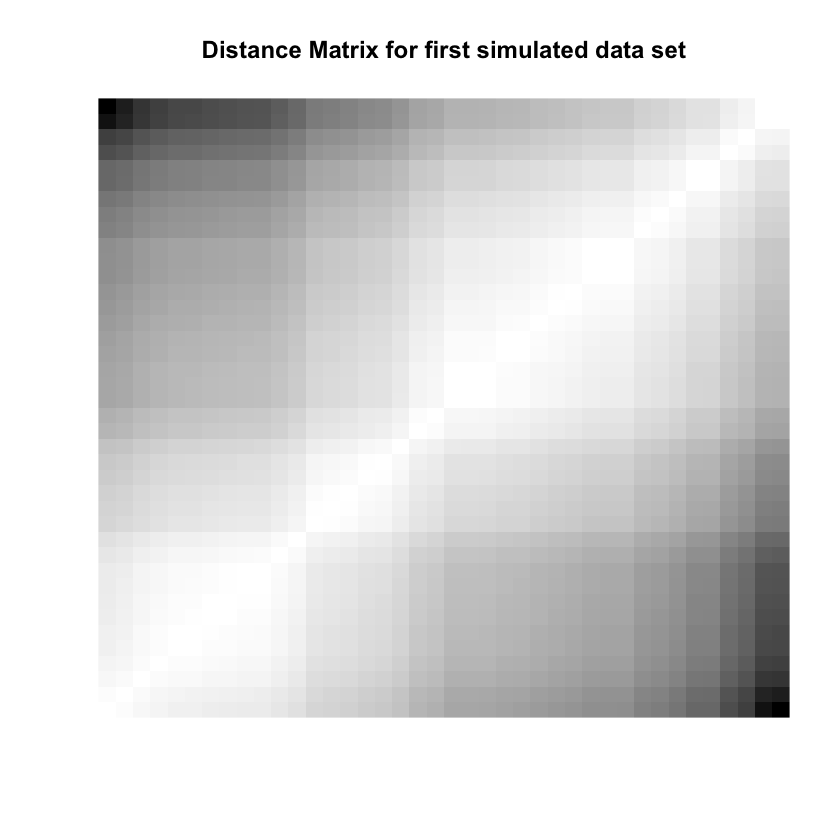

ERROR: Error in file(con, "rb"): cannot open the connection


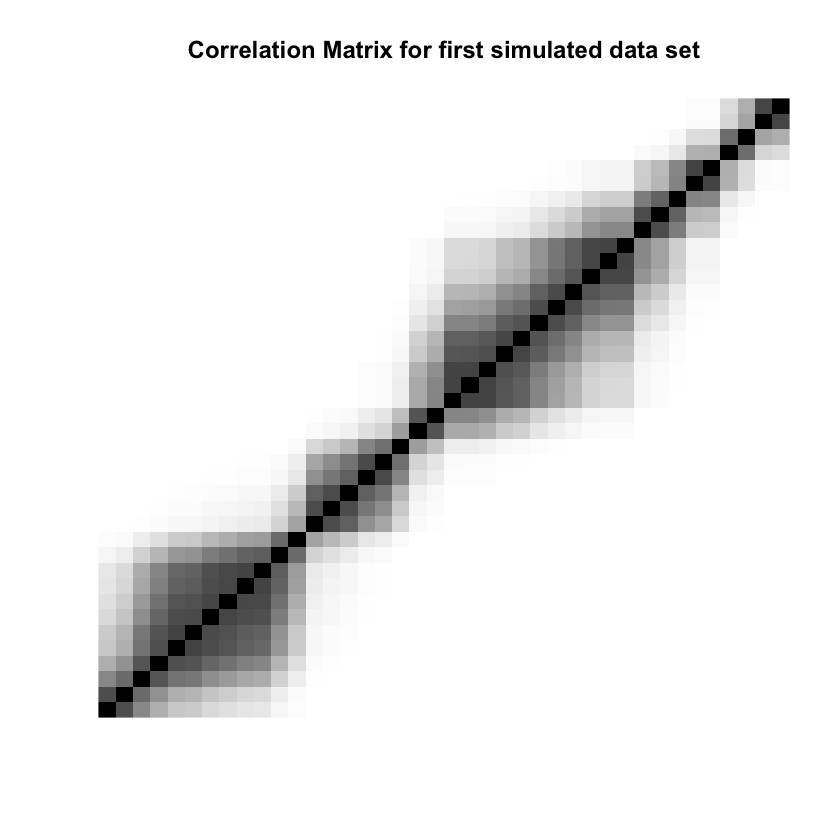

In [24]:
dist.1 = distances.x.star[[1]]
covMat.1 = covMat.star[[1]]
dim = ncol(dist.1)
image(1:dim, 1:dim, dist.1, axes = FALSE, xlab="", ylab="", 
      col = grey.colors(256,start=1.0,end=0.0), 
      main="Distance Matrix for first simulated data set")
image(1:dim, 1:dim, covMat.1, axes = FALSE, xlab="", ylab="", 
      col = grey.colors(256,start=1.0,end=0.0), 
      main="Correlation Matrix for first simulated data set")

In [25]:
#Now we'll divide up the response by region.
y1.star = y.star[, 1:n_per_region]
y2.star = y.star[, (n_per_region+1):(2*n_per_region)]

Let's check that the average difference in response between the two regions is
$5\beta + \mu$ (the 5 comes from the average distance between samples on the left and samples on the right). It looks good:

[1] 8.024398

[1] 8

ERROR: Error in file(con, "rb"): cannot open the connection


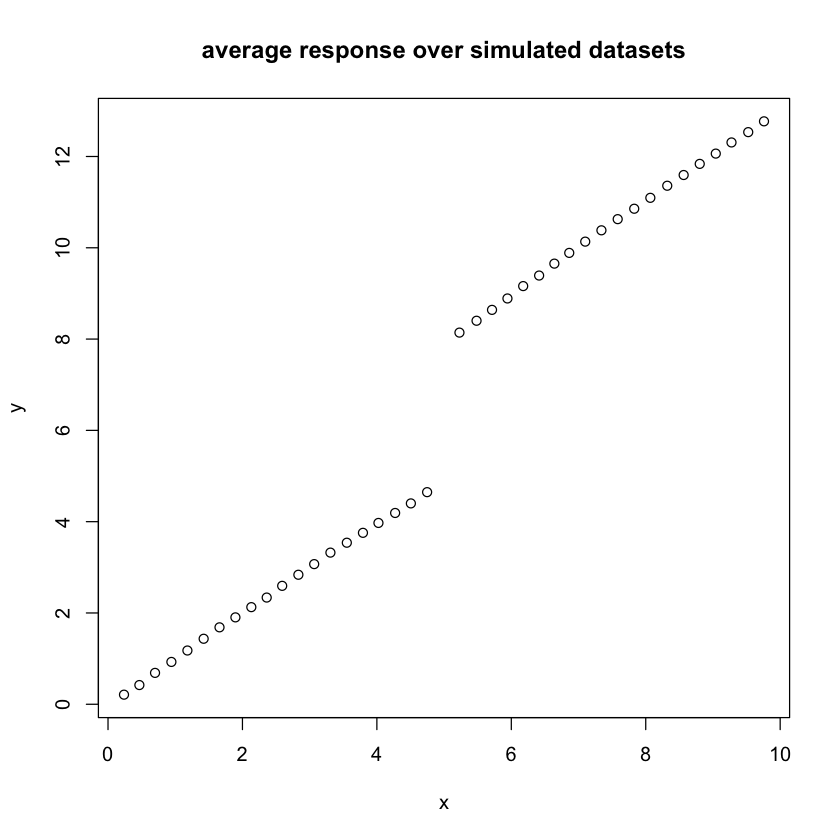

In [26]:
mean(y2.star) - mean(y1.star)
beta.star*5 + mu
plot(colMeans(x.star), colMeans(y.star), xlab="x", ylab="y",
     main="average response over simulated datasets")

We have several options for estimating the treatment effect:
1. We can fit a shifted GP model
2. We can fit two GPs (one in each region) and extrapolate
3. We can fit a derivative process in each region and extrapolate

# Shifted GP Model

In the `fitGPShift()` function, we use a "Stan fit object" called `gpShiftFitTest`.
`gpShiftFitTest` compiles the STAN model and then fits the model. By reusing the Stan fit object, we avoid repeating the compilation step (which takes some time).

In [27]:
gpShiftFitTest = stan(file = "shiftedGPFit.stan",
                      data =list(x=x.star[1,],y=y.star[1,],N=ncol(x.star)),
                      iter=20 ,chains=4)
#Note: Currently only runs one chain with 1,000 iterations;
#this has worked fine so far, but for more complicated models might want to do more
#chains/iterations.

#Function to fit the shifted GP model
#x1 are the values in the (0,5) region; x2 are values in the (5, 10) region
#same goes for y1, y2.
fitGPShift = function(x1, x2, y1, y2){
  data.listShift = list(x=c(x1,x2),
                        y=c(y1,y2),
                        N=length(x1)+length(x2))
  fit = stan(fit = gpShiftFitTest,
             data = data.listShift,
             iter = 500, chains = 4)
  print(fit)
  fit.extract = extract(fit, permuted=TRUE)
  return(fit.extract)
}

Warning message:
: There were 26 divergent transitions after warmup. Increasing adapt_delta may help.Warning message:
: Examine the pairs() plot to diagnose sampling problems


In [ ]:
#Create a list which contains the 1,000 fits for the shifted GP model
#(i.e., the fit of the model on each of the 1,000 datasets)
#This takes some time; created a list and wrote a for-loop to add to the list
#so you can stop the code and add to the list later, if necessary.
gpShiftFits = list()
for(i in 1:numberDatasets){
  gpShiftFits[[i]] = fitGPShift(x1=x1.star[i,], x2 = x2.star[i,],
                                y1 = y1.star[i,], y2 = y2.star[i,])
}

In [ ]:
#A 1000 x 3 matrix which contains the different estimates for the shift parameter
#and the corresponding credible intervals.
#The first column are the estimates (posterior median);
#the second column is the lower bound; the third column is the upper bound
ndidrun=length(gpShiftFits)
gpShiftFitsMatrix = matrix(nrow=ndidrun,ncol=4)
for(i in 1:ndidrun){
  gpShiftFitsMatrix[i,1] = as.numeric(quantile(gpShiftFits[[i]]$shift,
                                               probs = 0.5))
  gpShiftFitsMatrix[i,2] = as.numeric(quantile(gpShiftFits[[i]]$shift,
                                               probs = c(0.025,0.975))[1])
  gpShiftFitsMatrix[i,3] = as.numeric(quantile(gpShiftFits[[i]]$shift,
                                               probs = c(0.025,0.975))[2])
  gpShiftFitsMatrix[i,4] = as.numeric(mean(gpShiftFits[[i]]$shift))
}

In [ ]:
hist(gpShiftFitsMatrix[,1],breaks=10,main="posterior medians")

In [ ]:
#The true treatment effect is 3; which CIs contain 3?
length(which(gpShiftFitsMatrix[,2] <= 3 & gpShiftFitsMatrix[,3] >= 3))

#mean CI length

In [ ]:
mean(gpShiftFitsMatrix[,3]-gpShiftFitsMatrix[,2])

## Questions

1. In the STAN model, `shift` has a $\mathrm{Normal}(0,10)$ prior. Since there are only 40 data points, is it possible that we are simply witnessing the prior's regularisation effect? What happens if we replace that with a uniform?
2. What is the `nug_w` parameter in STAN? Should it just be eliminated?
    * apparently makes the chains mix better
    * ensures that the covariance matrix is invertible
3. The STAN model doesn't seem entirely stable (see warnings when running). What's going on there?
    * doesn't seem to be an issue
3. `Sigma_I` is a diagonal matrix. I think there would be a performance improvement from replacing
`y ~ multi_normal(mu_vec, Sigma_I)`
with 
`y ~ normal(mu_vec, tausq);`
4. Is the model *consistent*. If we have a ton of data does it find the right shift?
5. What the heck is `mu_w`? Why is it set to `y/4`? Shouldn't it be zero (the prior mean)? 
    * this was indeed an error

# Consistency

In [121]:
bigdata = gendata(200, sigmasq.star, phi.star, beta.star, tausq.star, mu)

In [93]:
bigdata.fit = stan(model_code="data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}

transformed data {
  matrix[N,N] xdist;
  vector[N] mu_w;
  real<lower=0> nug_w;

  for (i in 1:N) {
    mu_w[i] <- 0;
  }

  nug_w <- 0.001;
  
  for(i in 1:(N-1)){
    for(j in (i+1):N){
      xdist[i,j] <- exp( -pow(x[i] - x[j],2));
    }
  }
}

parameters {
  real shift;
  real beta;
  real<lower=0> sigmasq;
  real<lower=0> inv_phi;
  real<lower=0> tausq;

  vector[N] w_unit;
  
}

transformed parameters {
    real<lower=0> phi;
    phi <- inv(inv_phi);
}

model {
  vector[N] mu_vec;
  vector[N] w_s;
  {
  matrix[N,N] Kappa;  
  // off-diagonal elements
  for(i in 1:(N-1)){
    for(j in (i+1):N){
      Kappa[i,j] <- pow(xdist[i,j], phi);
      Kappa[j,i] <- Kappa[i,j];
    }
  }
  
  // diagonal elements
  for(k in 1:N){
    Kappa[k,k] <- 1 + nug_w;
  }

  w_s <- cholesky_decompose(Kappa) * (sqrt(sigmasq) * w_unit);
  for(i in 1:N){
    mu_vec[i] <- if_else(x[i] < 5, 0, shift) + x[i] * beta + w_s[i]; 
  }
  }

  
  sigmasq ~ cauchy(0,5);#inv_gamma(2, 0.1);
  inv_phi ~ cauchy(0,5);#gamma(2, 0.1);
  tausq ~ cauchy(0,5);#inv_gamma(2, 0.1);
  shift ~ normal(0, 10);
  beta ~ normal(0, 10);
  
  
  w_unit ~ normal(0, 1);
  // w_s ~ multi_normal(mu_w, Kappa);
  
  y ~ normal(mu_vec, tausq);
}
",
                      data=list(x=bigdata$x.star,y=bigdata$y,N=bigdata$n_per_region*2),
                      iter=100 ,chains=8)

Luke Bornn:

* discretize $\phi$ (can pre-compute Choleskies)
* knots (sparse covariance matrix)
* evenly spaced data (simplifies covariance somehow)

* Original model takes about 4 minutes for `n_per_region=50`.
* Pre-computing the distance matrix saves a negligible amount of time (10 seconds?)
* Reparametrizing by taking sigmasq outside of Kappa slowed sampling down significantly (goes up to 6 minutes)
* Using the Cholesky decomposition of the squared exponential covariance reduced the time back to 5 minutes
* for `n_per_region=100` (double the data), it took 46 minutes (9 times longer)

In [97]:
mu; beta.star; sigmasq.star; phi.star; tausq.star;

[1] 3

[1] 1

[1] 1

[1] 1.05

[1] 0.1

In [103]:
sapply(extract(bigdata.fit, c("shift", "beta", "sigmasq", "phi", "tausq")), FUN=mean)

shift      beta   sigmasq       phi     tausq 
2.9615263 0.9206352 1.6148990 1.2512625 0.3135904

This is encouraging as the posterior mean of `shift` is very close to the true value! However, $\sigma^2$ and $\tau^2$ are pretty far off.

ERROR: Error in file(con, "rb"): cannot open the connection


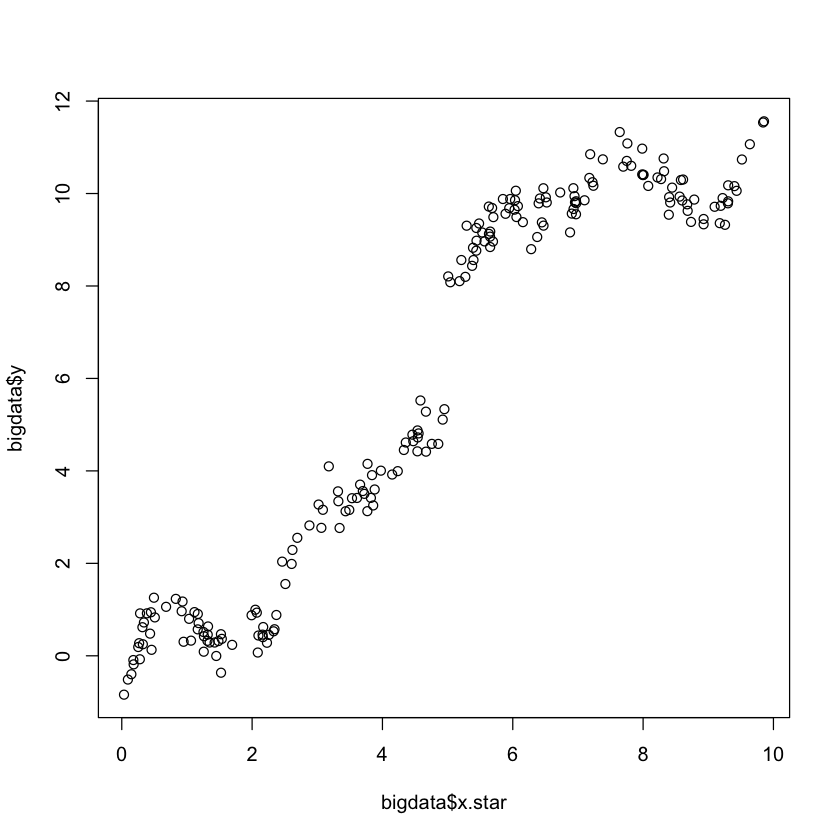

In [99]:
plot(bigdata$x.star, bigdata$y)

### $\phi$ known

Because the computation time for fitting the full hierarchical Gaussian process grows as $n^3$, it is difficult to verify consistency. Instead we will 

In [122]:
phiknown.fit = stan(model_code="data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  real<lower=0> phi;
}

transformed data {
  matrix[N,N] xdist;
  vector[N] mu_w;
  matrix[N,N] L;
  {
    matrix[N,N] Kappa; 

    for (i in 1:N) {
        mu_w[i] <- 0;
    }

    for(i in 1:(N-1)){
        for(j in (i+1):N){
          Kappa[i,j] <- exp( - phi*pow(x[i] - x[j],2));
          Kappa[j,i] <- Kappa[i,j];
        }
    }

    // diagonal elements
    for(k in 1:N){
        Kappa[k,k] <- 1 + 0.001;
        
    }
    L <- cholesky_decompose(Kappa);
  }


}

parameters {
  real shift;
  real beta;
  real<lower=0> sigmasq;
  real<lower=0> tausq;
  
  
  vector[N] w_unit; 
}

transformed parameters{
  vector[N] w_s;
  vector[N] mu_vec;
  w_s <- L * (sqrt(sigmasq) * w_unit);
  for(i in 1:N){
    mu_vec[i] <- if_else(x[i] < 5, 0, shift) + x[i] * beta + w_s[i]; 
  }
}

model {

  sigmasq ~ cauchy(0,5);#inv_gamma(2, 0.1);
  tausq ~ cauchy(0,5);#inv_gamma(2, 0.1);
  shift ~ normal(0, 10);
  beta ~ normal(0, 10);
  
  
  w_unit ~ normal(0, 1);
  // w_s ~ multi_normal(mu_w, Kappa);

  

  y ~ normal(mu_vec, tausq);
}
",
  data=list(x=bigdata$x.star,y=bigdata$y,N=bigdata$n_per_region*2, phi=phi.star),
  iter=1000 ,chains=8)

In [123]:
phiknown.fit

Inference for Stan model: a0be9e9908bc9713cb28213e0b188d6a.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

             mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
shift        3.30    0.00  0.18  2.94  3.17  3.30  3.43   3.67  4000 1.00
beta         0.98    0.00  0.08  0.82  0.92  0.98  1.03   1.14  3064 1.00
sigmasq      1.48    0.02  0.65  0.66  1.05  1.35  1.74   3.16  1229 1.01
tausq        0.30    0.00  0.01  0.28  0.30  0.30  0.31   0.33  4000 1.00
w_unit[1]    0.17    0.00  0.12 -0.05  0.09  0.17  0.24   0.40  4000 1.00
w_unit[2]   -0.18    0.02  1.02 -2.17 -0.89 -0.15  0.53   1.84  4000 1.00
w_unit[3]   -0.16    0.02  1.00 -2.09 -0.83 -0.15  0.50   1.78  4000 1.00
w_unit[4]   -0.52    0.01  0.67 -1.78 -0.98 -0.52 -0.06   0.76  4000 1.00
w_unit[5]    0.07    0.01  0.83 -1.54 -0.49  0.07  0.62   1.69  4000 1.00
w_unit[6]    0.00    0.02  0.96 -1.86 -0.65  0.00  0.65   1.85  4000 1.00
w_unit[7] 

In [128]:
sapply(extract(phiknown.fit, c("shift", "beta", "sigmasq", "tausq")), FUN=mean)

shift      beta   sigmasq     tausq 
3.3008667 0.9770788 1.4817008 0.3046366

In [130]:
list("mu"=mu,"beta"=beta.star, "sigmasq"=sigmasq.star, "phi"=phi.star, "tausq"=tausq.star)

$mu
[1] 3

$beta
[1] 1

$sigmasq
[1] 1

$phi
[1] 1.05

$tausq
[1] 0.1

# Testing Gaussian Processes in STAN

In [35]:
N <- 101L
x <- c(-5, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4, 
-3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3, -2.9, 
-2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2, -1.9, -1.8, 
-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1, -0.9, -0.8, -0.7, 
-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 
0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 
1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 
3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 
4.5, 4.6, 4.7, 4.8, 4.9, 5)
y <- c(1.04442478194401, 0.948306088493654, 0.357037759697332, 0.492336514646604, 
0.520651364364746, 0.112629866592809, 0.470995468454158, -0.168442254267804, 
0.0720344402575861, -0.188108980535916, -0.0160163306512027, 
-0.0388792158617705, -0.0600673630622568, 0.113568725264636, 
0.447160403837629, 0.664421188556779, -0.139510743820276, 0.458823971660986, 
0.141214654640904, -0.286957663528091, -0.466537724021695, -0.308185884317105, 
-1.57664872694079, -1.44463024170082, -1.51206214603847, -1.49393593601901, 
-2.02292464164487, -1.57047488853653, -1.22973445533419, -1.51502367058357, 
-1.41493587255224, -1.10140254663611, -0.591866485375275, -1.08781838696462, 
-0.800375653733931, -1.00764767602679, -0.0471028950122742, -0.536820626879737, 
-0.151688056391446, -0.176771681318393, -0.240094952335518, -1.16827876746502, 
-0.493597351974992, -0.831683011472805, -0.152347043914137, 0.0190364158178343, 
-1.09355955218051, -0.328157917911376, -0.585575679802941, -0.472837120425201, 
-0.503633622750049, -0.0124446353828312, -0.465529814250314, 
-0.101621725887347, -0.26988462590405, 0.398726664193302, 0.113805181040188, 
0.331353802465398, 0.383592361618461, 0.431647298655434, 0.580036473774238, 
0.830404669466897, 1.17919105883462, 0.871037583886711, 1.12290553424174, 
0.752564860804382, 0.76897960270623, 1.14738839410786, 0.773151715269892, 
0.700611498974798, 0.0412951045437818, 0.303526087747629, -0.139399513324585, 
-0.862987735433697, -1.23399179134008, -1.58924289116396, -1.35105117911049, 
-0.990144529089174, -1.91175364127672, -1.31836236129543, -1.65955735224704, 
-1.83516148300526, -2.03817062501248, -1.66764011409214, -0.552154350554687, 
-0.547807883952654, -0.905389222477036, -0.737156477425302, -0.40211249920415, 
0.129669958952991, 0.271142753510592, 0.176311762529962, 0.283580281859344, 
0.635808289696458, 1.69976647982837, 1.10748978734239, 0.365412229181044, 
0.788821368082444, 0.879731888124867, 1.02180766619069, 0.551526067300283)

In [45]:
stan.fit = stan(model_code="data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
transformed data {
  vector[N] mu;
  for (i in 1:N) 
    mu[i] <- 0;
}
parameters {
  real<lower=0> eta_sq;
  real<lower=0> rho_sq;
  real<lower=0> sigma_sq;
}
model {
  matrix[N,N] Sigma;

  // off-diagonal elements
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      Sigma[i,j] <- eta_sq * exp(-rho_sq * pow(x[i] - x[j],2));
      Sigma[j,i] <- Sigma[i,j];
    }
  }

  // diagonal elements
  for (k in 1:N)
    Sigma[k,k] <- eta_sq + sigma_sq; // + jitter

  eta_sq ~ cauchy(0,5);
  rho_sq ~ cauchy(0,5);
  sigma_sq ~ cauchy(0,5);

  y ~ multi_normal(mu,Sigma);
}",
                data=list(x=x,y=y,N=length(y)),
                      iter=1000 ,chains=8)

In [50]:
stan.fit

Inference for Stan model: 521f2af5e75ec258c95e1c73bb017581.
8 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=4000.

          mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
eta_sq    1.22    0.02 0.80  0.42  0.73  1.00  1.43  3.45  1212    1
rho_sq    1.06    0.01 0.33  0.59  0.83  1.00  1.23  1.85  1562    1
sigma_sq  0.10    0.00 0.02  0.07  0.09  0.10  0.11  0.14  1648    1
lp__     37.34    0.04 1.27 33.99 36.81 37.66 38.27 38.78  1037    1

Samples were drawn using NUTS(diag_e) at Wed Nov 25 14:11:42 2015.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

# Fit Two Gaussian Processes

In [ ]:
##Now we'll fit two GPs (one in each region) and extrapolate
#Similar to fitting the shifted GP model,
#we'll run the C++ code once,
#and then create functions that point to these "Stan fit objects".
gpFit1.test = stan(file = "gp2fit.stan",
                   data=list(x=x1.star[1,],
                             y=y1.star[1,],
                             N = length(x1.star[1,])),
                   iter=1000,chains=1)
gpFit2.test = stan(file = "gp2fit.stan",
                   data=list(x=x2.star[1,],
                             y=y2.star[1,],
                             N = length(x2.star[1,])),
                   iter=1000,chains=1)

#Function for fitting a GP in the left-hand (0, 5) region
fitGP1 = function(x1, y1){
  data.list1 = list(x=x1,
                    y=y1,
                    N=length(x1))
  
  gpFit1 <- stan(fit=gpFit1.test,
                 data=data.list1,
                 iter=1000, chains = 1)
  #Note: permuted = TRUE means the draws are taken AFTER burn-in
  #could set permuted = FALSE to keep ALL draws.
  gpFit1.extract = extract(gpFit1, permuted=TRUE)
  return(gpFit1.extract)
}
#Function for fitting a GP in the right-hand (5, 10) region
fitGP2 = function(x2, y2){
  data.list2 = list(x=x2,
                    y=y2,
                    N=length(x2))
  gpFit2 <- stan(fit=gpFit2.test,
                 data=data.list2,
                 iter=1000, chains = 1)
  gpFit2.extract = extract(gpFit2, permuted=TRUE)
  return(gpFit2.extract)
}

#Create a list, where each item corresponds to fitting a GP to a different dataset
#We create two different lists, one for each region, so we can analyze any noticeable
#differences between the left-hand and right-hand GPs.
gpFit1s = list(); gpFit2s = list()
for(i in 1:nrow(x1.star)){
  gpFit1s[[i]] = fitGP1(x1.star[i,], y1.star[i,])
  gpFit2s[[i]] = fitGP2(x2.star[i,], y2.star[i,])
}

#Draw from the posterior of each GP
#postPredY1Draws are posterior predictive draws for the left-hand GP;
#postPredY2Draws are posterior predictive draws for the right-hand GP.
postPredY1Draws = postPredY2Draws = replicate(length(gpFit1s),
                                      matrix(nrow = length(gpFit1s[[1]]$mu),
                                             ncol = ncol(x1.star)),
                                      simplify = FALSE)
#The index m corresponds to each of the 500 posterior draws for each parameter
#(i.e., mean of the GP, sigmasq, and tausq).
#Thus, for each draw from a parameter's posterior, we are drawing from
#the posterior predictive distribution for the response surface.
for(i in 1:length(postPredY1Draws)){
  for(m in 1:nrow(postPredY1Draws[[1]])){
    postPredY1Draws[[i]][m,] = mvrnorm(1, mu = gpFit1s[[i]]$mu_vec[m,],
                               Sigma = diag(gpFit1s[[i]]$sigmasq[m] + gpFit1s[[i]]$tausq[m],
                                            ncol(x1.star)))
    postPredY2Draws[[i]][m,] = mvrnorm(1, mu = gpFit2s[[i]]$mu_vec[m,],
                               Sigma = diag(gpFit2s[[i]]$sigmasq[m] + gpFit2s[[i]]$tausq[m],
                                            ncol(x2.star)))
  }
}




#joint kriging

#  mu, beta, sigmasq, tausq, and phi are all parameters, and 500 draws
#of each are already obtained from the Stan model.
#  X is spatial data
#  Y is response surface data
#  predX are new spatial data (that we have to do kriging on, because we
#don't have the corresponding Y values for each predX value).
#For example, if our right-most observation in the LEFT-HAND region is 4.5,
#predX will be values between 4.5 and 5.
drawKrigingY = function(n, mu, beta, sigmasq, tausq, phi, X, Y, predX){
  
  #First we need distances among the X values
  distances = matrix(nrow=length(X), ncol=length(X))
  for(i in
      1:length(X)){
    for(j in 1:length(X)){
      distances[i,j] = X[i] - X[j]
    }
  }
  #and now we need the distances among the *new* X values
  predDistances = matrix(nrow=length(predX), ncol=length(predX))
  for(i in 1:length(predX)){
    for(j in 1:length(predX)){
      predDistances[i,j] = predX[i] - predX[j]
    }
  }
  #and also we need the distances between each of the X values and the *new* X values
  predXDistances = t(sapply(X, function(x) x - predX))
  
  #Recall that mu is one of our paramters whose posterior we already drew from
  #using the Stan model.
  #Thus, for each posterior draw of the parameters, we'll draw from the posterior
  #predictive distribution for each new X (i.e., each predX)
  #Thus, we'll have length(mu)-many draws from the posterior predictive distribution.
  posteriorPredictiveDraws = matrix(nrow = length(mu), ncol = length(predX))
  for(m in 1:length(mu)){
    
    #the covariance matrix for the Xs is
    estCovMat = sigmasq[m]*exp(-phi[m]*distances^2) + diag(tausq[m], length(X))
    #and the covariance matrix for the new Xs is
    predCovMat = sigmasq[m]*exp(-phi[m]*predDistances^2)
    #and the covariance matrix between the Xs and new Xs is
    predCrossCovMat = sigmasq[m]*exp(-phi[m]*predXDistances^2) 
    
    #using conditional MVN theory, we can find the distribution of
    #p(predX | X, Y, theta)
    #the mean of this distribution is
    predYMean = mu[m] + predX*beta[m] + t(predCrossCovMat)%*%solve(estCovMat)%*%(Y - (mu[m] + X*beta[m]))
    #and the covariance matrix of this distribution is
    predYCovMat = predCovMat - t(predCrossCovMat)%*%solve(estCovMat)%*%predCrossCovMat
    #Therefore, using the above mean and covariance, we can draw from the posterior
    #predictive distribution for each predX.
    posteriorPredictiveDraws[m,] = mvrnorm(n = n, mu = predYMean, Sigma = predYCovMat)
  }
  return(posteriorPredictiveDraws)
} 


#draws from the posterior predictive distribution of both GPs (one in each region)
krigingDrawsY1=krigingDrawsY2=list() 
predX1 = predX2 = matrix(nrow = nrow(x1.star), ncol = 50)

#predX1 is the right-most x value in the LEFT-HAND region to 5
#predX2 is 5 up to the left-most x value in the  RIGHT-HAND region.
#Thus, krigingDrawsY1 are the y values that we would predict if
#we were given, say, x values between 4.5 and 5
#And krigingDraws Y2 are the y values that we would predict if
#we were given, say, x values between 5 and 5.5
for(i in 1:length(gpFit1s)){
  predX1[i,] = seq(x1.star[i,ncol(x1.star)], 5, length = 50)
  predX2[i,] = seq(5, x2.star[i, 1], length = 50)
  krigingDrawsY1[[i]] = drawKrigingY(n=1,gpFit1s[[i]]$mu,gpFit1s[[i]]$beta,
                                             gpFit1s[[i]]$sigmasq,gpFit1s[[i]]$tausq,
                                             gpFit1s[[i]]$phi,
                                             X=x1.star[i,],Y=y1.star[i,],predX=predX1[i,])
  krigingDrawsY2[[i]] = drawKrigingY(n=1,gpFit2s[[i]]$mu,gpFit2s[[i]]$beta,
                                             gpFit2s[[i]]$sigmasq,gpFit2s[[i]]$tausq,
                                             gpFit2s[[i]]$phi,
                                             X=x2.star[i,],Y=y2.star[i,],predX=predX2[i,])
}

#Averaging over the kriging draws so we can have an estimated y for each predX
krigingDrawsY1Mean = krigingDrawsY2Mean = 
  matrix(nrow=length(krigingDrawsY1), ncol = length(predX1))
for(i in 1:length(krigingDrawsY1)){
  krigingDrawsY1Mean[i,] = colMeans(krigingDrawsY1[[i]])
  krigingDrawsY2Mean[i,] = colMeans(krigingDrawsY2[[i]])
}

##PLOT SHOWING EXTRAPOLATION VIA TWO GPs
plot(c(x1,x2), c(y1,y2))
lines(x1, colMeans(postPredY1Draws))
lines(x2, colMeans(postPredY2Draws))
abline(v = 5)
#interal lines
for(i in 1:nrow(krigingDrawsY1)){
  lines(predX1, krigingDrawsY1[i,], col = "gray")
  lines(predX2, krigingDrawsY2[i,], col = "gray")
}
#mean lines
lines(predX1, krigingDrawsY1Mean, col = "purple")
lines(predX2, krigingDrawsY2Mean, col = "purple")

#Plot showing a few extrapolations via 2 GPs
par(mfrow=c(3,3))
for(i in 1:9){
  plot(x.star[i,],y.star[i,])
  lines(predX1, colMeans(krigingDrawsY1[[i]]), col = "purple")
  lines(predX2, colMeans(krigingDrawsY2[[i]]), col = "purple")
  abline(v=5)
}

#Our estimated treatment effect will be the difference between two values:
#   1) The value we would expect at x = 5 for the left-hand GP
#   2) The value we would expect at x = 5 for the right-hand GP

#estEffect2GPs contains the estimated treatment effect via the 2 GPs method.
estEffect2GPs = matrix(nrow = length(krigingDrawsY1),
                             ncol = nrow(krigingDrawsY1[[1]]))
for(i in 1:length(krigingDrawsY1)){
  for(j in 1:nrow(krigingDrawsY1[[1]])){
    estEffect2GPs[i,j] = krigingDrawsY2[[i]][j,1] - krigingDrawsY1[[i]][j,length(predX1[i,])]
  }
}

#Now we'll create a matrix that contains the estimated effect and 95% CI for
#each simulated data set.
#First column corresponds to estimated treatment effects;
#second and third columns are lower and upper bounds of CIs
estEffect2GPsMatrix = matrix(nrow=length(krigingDrawsY1), ncol = 3)
for(i in 1:length(krigingDrawsY1)){
  estEffect2GPsMatrix[i,1] = as.numeric(quantile(estEffect2GPs[i,],
                                                 probs = 0.5))
  estEffect2GPsMatrix[i,2] = as.numeric(quantile(estEffect2GPs[i,],
                                                       probs = c(0.025,0.975)))[1]
  estEffect2GPsMatrix[i,3] = as.numeric(quantile(estEffect2GPs[i,],
                                                       probs = c(0.025,0.975)))[2]
}
#How many CIs contain the true treatment effect of 3?
length(which(estEffect2GPsMatrix[,2] <= 3 & estEffect2GPsMatrix[,3] >= 3))
#Mean CI length
mean(estEffect2GPsMatrix[,3] - estEffect2GPsMatrix[,2])

#Can think about which datasets contain observations closest to the boundary:
#Which datasets have the largest gaps between regions?
xGapDistances = x2.star[,1]-x1.star[,ncol(x1.star)]
xGapCutOff = as.numeric(quantile(xGapDistances, probs = 0.5))
smallGapIndex = which(xGapDistances < xGapCutOff)
largeGapIndex = which(xGapDistances >= xGapCutOff)
#Is the coverage for datasets with a small gap better than
#that of datasets with a large gap?
length(which(estEffect2GPsMatrix[smallGapIndex,2] <= 3 & estEffect2GPsMatrix[smallGapIndex,3] >= 3))
length(which(estEffect2GPsMatrix[largeGapIndex,2] <= 3 & estEffect2GPsMatrix[largeGapIndex,3] >= 3))

##################################
##DIRECTIONAL DERIVATIVE PROCESS##
##################################

#The easiest way to estimate a directional derivative is to estimate the directive.
#We do this by performing kriging on our observations closest to the boundary,
#and then perform kriging on an x value very close to this observation,
#and then calculate the slope of the estimated y for each of these points.
#Banerjee (2003) shows that this is a close approximation
#to the "true directional derivative"

#h is how far away we perform kriging from our observation closest to the boundary
#We want h to be small (Banerjee 2003 suggests h = 0.01)
#u is the "direction"; because we are in one dimension, u = 1, but u can be
#more complicated for high dimensions.
#For example, if we wanted to estimate the derivative to the northeast in two-dimensions,
#u = (0.5, 0.5).
h = 0.01; u = 1
#Observation in (0,5) closest to the boundary
predX1Closest = x1.star[1,ncol(x1.star)]
#Observation in (5, 10) closest to the boundary
predX2Closest = x2.star[1,1]

#The x values that we will perform kriging on
#x1H and x2H are simply perturbations around the observations closest to the boundary
x1H = predX1Closest - h*u
x2H = predX2Closest + h*u

#Now we'll obtain kriging draws for these perturbed values
predY1andYH=predY2andYH=replicate(1000, matrix(nrow=500,ncol=2),simplify=FALSE)
#and also estimate the derivative in the left-hand and right-hand regions
estDeriv1=estDeriv2=
  y1EstDeriv=y2EstDeriv=
  estDerivEffect=matrix(nrow=1000,ncol=500)
#We'll do this for each of the 1,000 datasets
for(i in 1:1000){
  #These are our observed values closest to the boundary
  predX1Closest = x1.star[i,ncol(x1.star)]
  predX2Closest = x2.star[i,1]
  #These are our perturbations around these closest observed values
  x1H = predX1Closest - h*u
  x2H = predX2Closest + h*u
  #Perform kriging on the observations closest to the boundary and
  #the perturbed values

  #left-hand region
  predY1andYH[[i]] = drawKrigingY(n=1, gpFit1s[[i]]$mu,
                                       gpFit1s[[i]]$beta,
                                       gpFit1s[[i]]$sigmasq,
                                       gpFit1s[[i]]$tausq,
                                       gpFit1s[[i]]$phi,
                                       X = x1.star[i,], Y = y1.star[i,],
                                       predX = c(x1H, predX1Closest))
  #right-hand region
  predY2andYH[[i]] = drawKrigingY(n=1, gpFit2s[[i]]$mu,
                                       gpFit2s[[i]]$beta,
                                       gpFit2s[[i]]$sigmasq,
                                       gpFit2s[[i]]$tausq,
                                       gpFit2s[[i]]$phi,
                                       X = x2.star[i,], Y = y2.star[i,],
                                       predX = c(predX2Closest, x2H))
  
  #The estimated derivative on both sides
  estDeriv1[i,] = (predY1andYH[[i]][,2] - predY1andYH[[i]][,1])/h
  estDeriv2[i,] = (predY2andYH[[i]][,1] - predY2andYH[[i]][,2])/h

  #Now that we've estimated the derivative in the left-hand and right-hand regions,
  #we extrapolate to the boundary via the estimated derivative 
  #In other words, we are again estimating what the y value should be at x = 5
  #given the estimated derivative for the left-hand side, and doing the
  #same thing for the right-hand side.
  y1EstDeriv[i,] = predY1andYH[[i]][,2] + (5-predX1Closest)*estDeriv1[i,]
  y2EstDeriv[i,] = predY2andYH[[i]][,1] + (predX2Closest-5)*estDeriv2[i,]
  
  #The estimated treatment effect is the difference between the value we estimate
  #at x = 5 for the left-hand side and that of the right-hand side.
  estDerivEffect[i,] = y2EstDeriv[i,]-y1EstDeriv[i,]
}

#1000 x 3 matrix, where the first column contains the estimated treatment effect
#via the directional derivative process, and the second and third columns
#contain the lower and upper bounds of the corresponding credible intervals.
estDerivEffectMatrix = matrix(nrow=1000,ncol=3)
for(i in 1:1000){
  estDerivEffectMatrix[i,1] = mean(estDerivEffect[i,])
  estDerivEffectMatrix[i,2] = as.numeric(quantile(estDerivEffect[i,],
                                                      prob = c(0.025,0.975))[1])
  estDerivEffectMatrix[i,3] = as.numeric(quantile(estDerivEffect[i,],
                                                      prob = c(0.025,0.975))[2])
}

#Which CIs contain the true treatment effect of 3?
length(which(estDerivEffectMatrix[,2] <= 3 & estDerivEffectMatrix[,3] >= 3))
#average length of CIs
mean(estDerivEffectMatrix[,3] - estDerivEffectMatrix[,2])
#average length of CIs for datasets with observations far from the boundary
#as well as for datasets with observations close to the boundary.
mean(estDerivEffectMatrix[largeGapIndex,3]-estDerivEffectMatrix[largeGapIndex,2])
mean(estDerivEffectMatrix[smallGapIndex,3]-estDerivEffectMatrix[smallGapIndex,2])

#Plots showing the directional derivative process for some datasets
par(mfrow=c(3,3))
for(i in 1:9){
  plot(c(x1.star[i,],x2.star[i,]),c(y1.star[i,],y2.star[i,]),
       xlab = "locations", ylab = "response")
  lines(x1.star[i,], colMeans(postPredY1Draws[[i]]), col = "purple")
  lines(x2.star[i,], colMeans(postPredY2Draws[[i]]), col = "purple")
  lines(predX1[i,], colMeans(krigingDrawsY1[[i]]), col = "purple")
  lines(predX2[i,], colMeans(krigingDrawsY2[[i]]), col = "purple")
  lines(c(x1.star[i,20], 5), c(mean(predY1andYH[[i]][,2]), mean(y1EstDeriv[i,])),
        col="green")
  lines(c(5, x2.star[i,1]), c(mean(y2EstDeriv[i,]), mean(predY2andYH[[i]][,2])),
        col="green")
  abline(v=5)
}